In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sql
import pymysql
import sklearn.linear_model as skllm
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps
import time

%matplotlib inline

In [2]:
sns.set_context('talk')

In [3]:
#connect to db
zidisha_db = qdb.QueryDatabase('zidisha')

In [4]:
sql_dir = 'SQL_queries'

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

In [5]:
time_bins_edge = pd.date_range('2014-04-01','2015-09-01', None, '2W')
#time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
#time_bins_edge = pd.date_range('2013-04-01','2015-09-01', None, '3W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

#list_df_new_borrowers_count = bd.bin_list_time(time_bins_edge, list_df_new_borrowers, bin_type='count', binned_col_labels=labels_countries)
#list_df_first_loans_count = bd.bin_list_time(time_bins_edge, list_df_first_loans, bin_type='count', binned_col_labels=labels_countries)
#list_df_total_borrowers = bd.bin_list_time(time_bins_edge, list_df_new_borrowers, bin_type='mean', binned_col_labels=labels_countries)
#list_df_total_first_loans = bd.bin_list_time(time_bins_edge, list_df_first_loans, bin_type='mean', binned_col_labels=labels_countries)

# Policies
df_loan_loss_fee = load_Zidisha.loan_loss_reserve_fee(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)


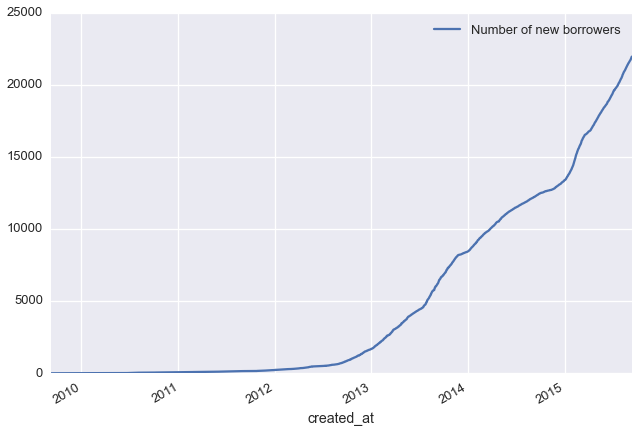

In [6]:
list_df_new_borrowers[0].plot()

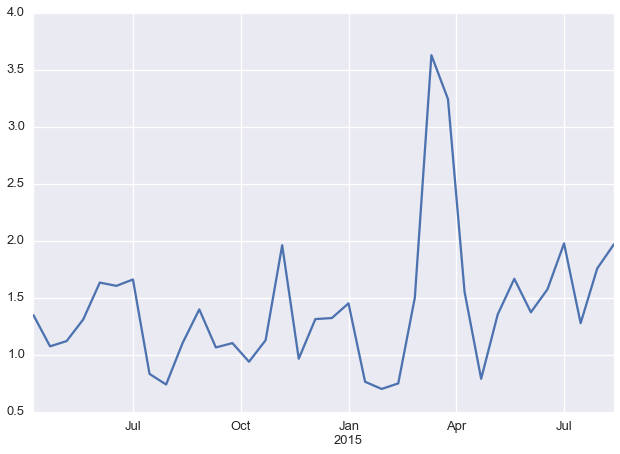

In [7]:
df_time_to_disbursement.All.plot()

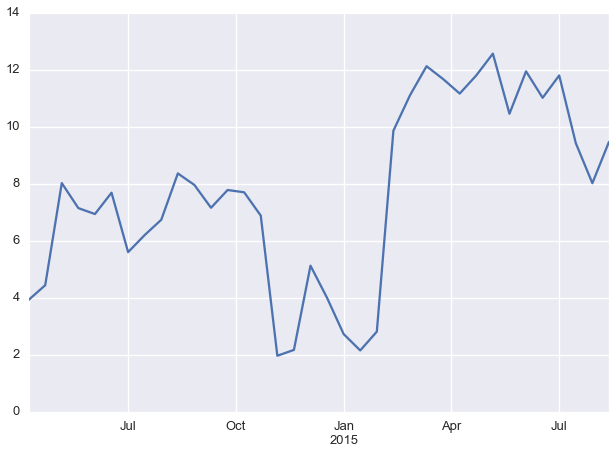

In [8]:
df_time_to_fund.All.plot()

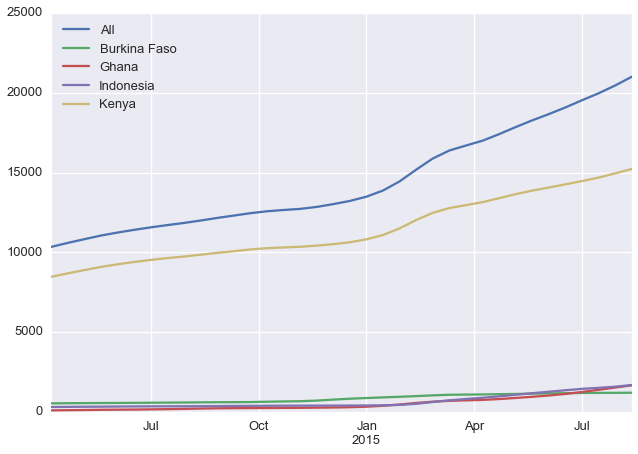

In [9]:
df_total_borrowers.plot()

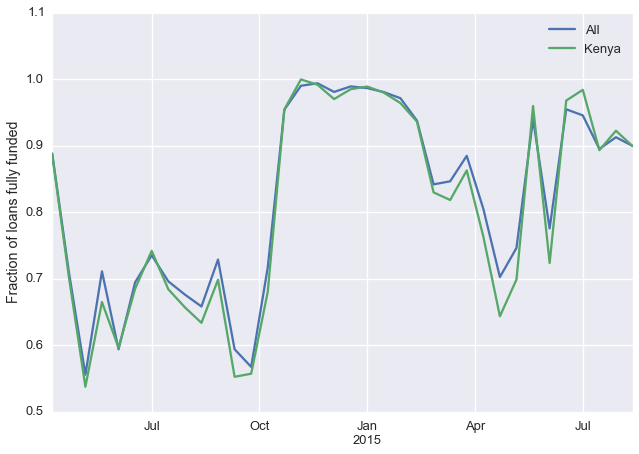

In [10]:
df_fund_rate[['All','Kenya']].plot()
plt.ylabel('Fraction of loans fully funded')

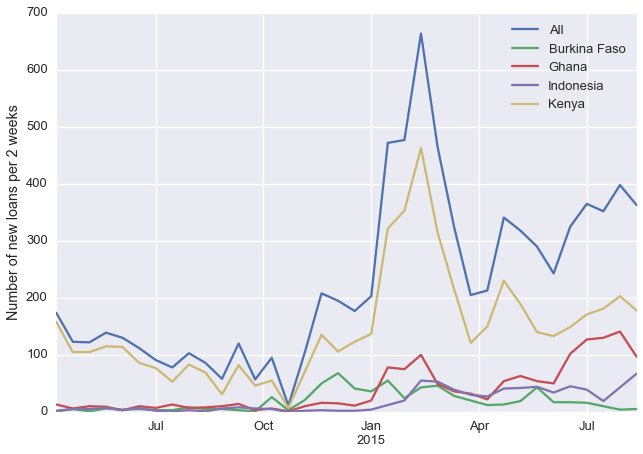

In [11]:
df_first_loans_count.plot()
plt.ylabel('Number of new loans per 2 weeks')

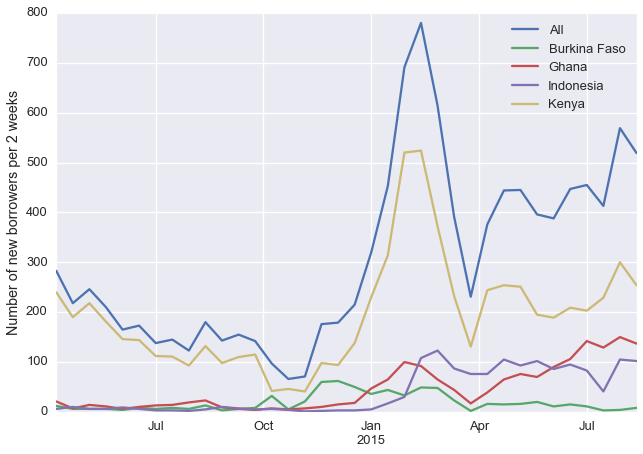

In [12]:
df_new_borrowers_count.plot()
plt.ylabel('Number of new borrowers per 2 weeks')

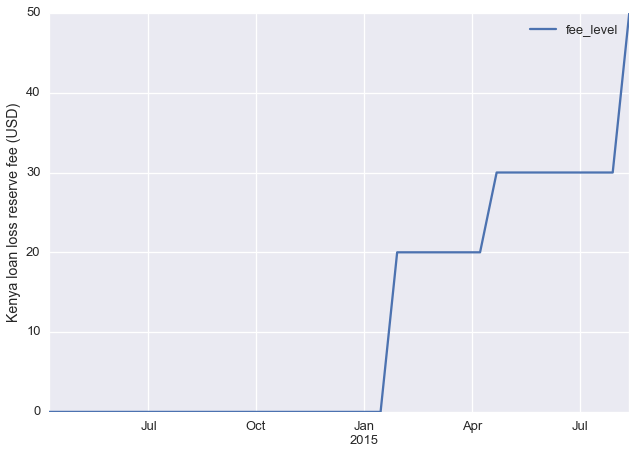

In [13]:
df_loan_loss_fee.plot()
plt.ylabel('Kenya loan loss reserve fee (USD)')

(0, 200)

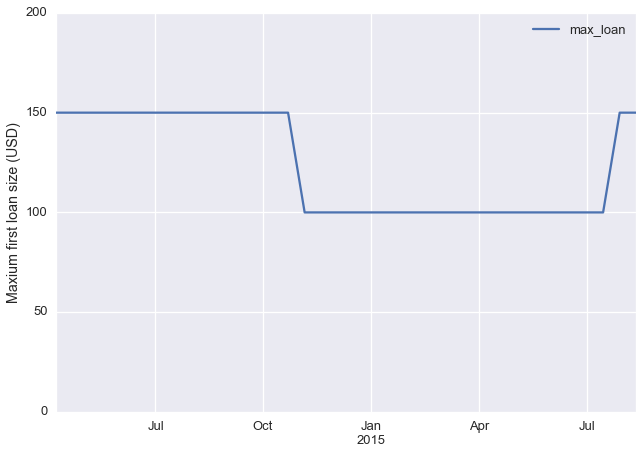

In [14]:
df_max_first_loan.plot()
plt.ylabel('Maxium first loan size (USD)')
plt.ylim([0, 200])

(0, 11)

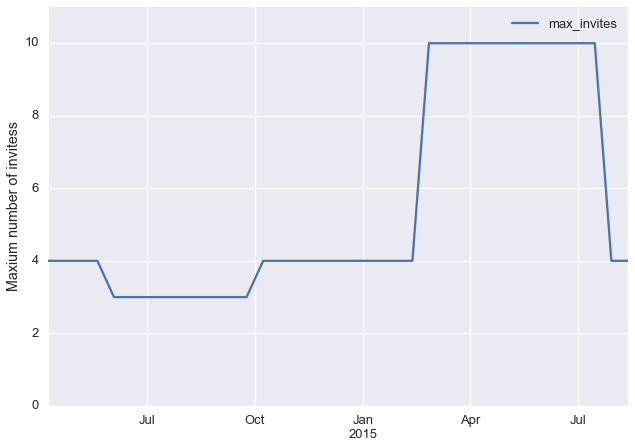

In [15]:
df_max_invites.plot()
plt.ylabel('Maxium number of invitess')
plt.ylim([0, 11])

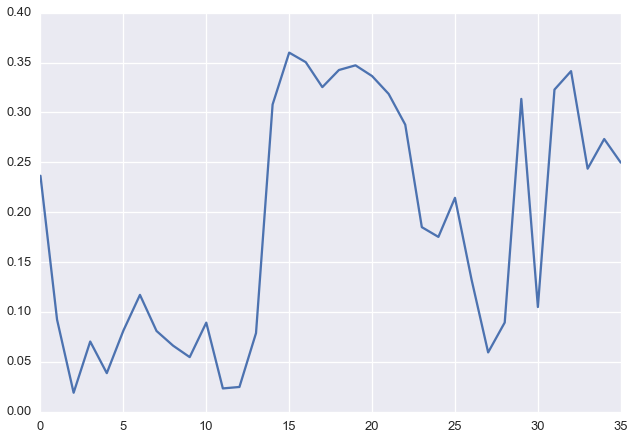

In [16]:
fund_rate_feature = df_fund_rate.Kenya.values
fund_rate_feature = (fund_rate_feature-0.4)**2
plt.plot(fund_rate_feature)

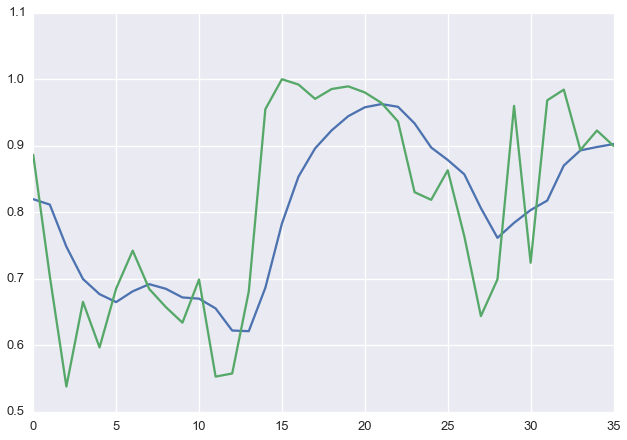

In [18]:
b, a = sps.iirfilter(1, (0, 0.125))
fund_rate_feature = df_fund_rate.Kenya.values
raw_data = np.copy(fund_rate_feature)
init_cond_out = np.zeros(len(a)-1)
init_cond_in = np.zeros(len(b)-1)
mean_offset = np.mean(raw_data)
raw_data = sps.lfilter(b, a, raw_data-mean_offset, zi=sps.lfiltic(b, a, init_cond_out, x=init_cond_in))[0]+mean_offset
plt.plot(raw_data)
plt.plot(fund_rate_feature)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     13.65
Date:                Wed, 23 Sep 2015   Prob (F-statistic):           1.58e-06
Time:                        12:13:14   Log-Likelihood:                -202.29
No. Observations:                  36   AIC:                             414.6
Df Residuals:                      31   BIC:                             422.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1269.6375    295.956      4.290      0.0

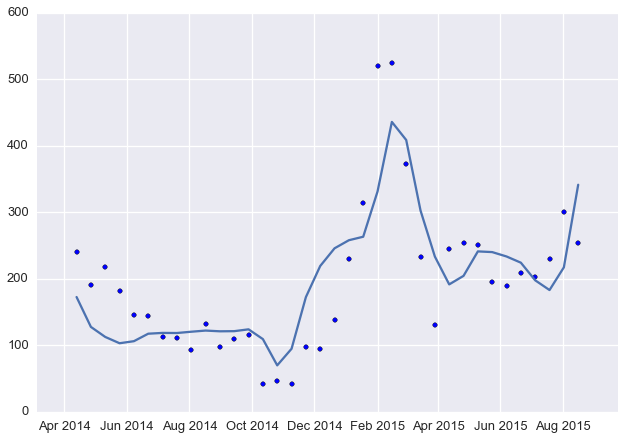

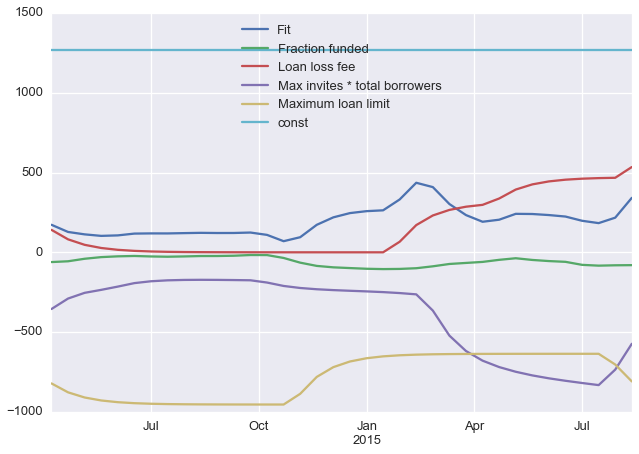

In [20]:
# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
lag = 0
if lag > 0:
    invite_feature = df_total_borrowers.Kenya.values[:-lag] * df_max_invites.max_invites.values[:-lag]
    fund_rate_feature = df_fund_rate.Kenya.values[:-lag]
    max_loan_feature = df_max_first_loan.max_loan.values[:-lag]
    loan_loss_fee = df_loan_loss_fee.fee_level.values[:-lag]

    label_array = df_new_borrowers_count.Kenya.values[lag:]
    time_axis = time_bins_center[:-lag]
elif lag < 0:
    invite_feature = df_total_borrowers.Kenya.values[:lag] * df_max_invites.max_invites.values[:lag]
    fund_rate_feature = df_fund_rate.Kenya.values[:lag]
    max_loan_feature = df_max_first_loan.max_loan.values[:lag]
    loan_loss_fee = df_loan_loss_fee.fee_level.values[:lag]

    label_array = df_new_borrowers_count.Kenya.values[-lag:]
    time_axis = time_bins_center[:lag]
else:
    invite_feature = df_total_borrowers.Kenya.values * df_max_invites.max_invites.values
    fund_rate_feature = df_fund_rate.Kenya.values
    max_loan_feature = df_max_first_loan.max_loan.values
    loan_loss_fee = df_loan_loss_fee.fee_level.values

    label_array = df_new_borrowers_count.Kenya.values
    time_axis = time_bins_center

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

lag = 3
if lag:
    b, a = sps.iirfilter(1, (0, 1.0/(2*lag)))
    init_cond_out = np.zeros(len(a)-1)
    init_cond_in = np.zeros(len(b)-1)
    filt_init = sps.lfiltic(b, a, init_cond_out, x=init_cond_in)
    
    mean_offset = np.mean(invite_feature)
    invite_feature = sps.lfilter(b, a, invite_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(fund_rate_feature)
    fund_rate_feature = sps.lfilter(b, a, fund_rate_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(max_loan_feature)
    max_loan_feature = sps.lfilter(b, a, max_loan_feature-mean_offset, zi=filt_init)[0] + mean_offset
    mean_offset = np.mean(loan_loss_fee)
    loan_loss_fee = sps.lfilter(b, a, loan_loss_fee-mean_offset, zi=filt_init)[0] + mean_offset


const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, invite_feature, fund_rate_feature, max_loan_feature, loan_loss_fee]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Max invites * total borrowers', 'x2: Fraction funded', 'x3: Maximum loan limit', 'x4: Loan loss fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Max invites * total borrowers','Fraction funded','Maximum loan limit', 'Loan loss fee']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

In [ ]:
plt.scatter(time_axis, label_array)
plt.plot(time_axis, results.predict())

In [ ]:
#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['const','Max invites * total borrowers','Fraction funded','Maximum loan limit']
df_dict = {'Fit': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

In [ ]:
plot_lists.individual(bd.bin_data_frame_to_list(df_new_borrowers_count))

In [ ]:
for df in list_df_total_first_loans:
    df.plot()

In [ ]:
for index in range(len(labels_countries)):
    list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    if list_df_total_first_loans[index].max()[0] > 600:
        list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    plt.plot(time)
    list_df_new_borrowers_count[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    list_df_new_borrowers_count[index].plot()

In [ ]:
list_df_new_borrowers[1]

In [ ]:
for df in list_df_new_borrowers:
    print(type(df))

In [ ]:
df_new_borrowers.columns.tolist()[0]

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

In [ ]:
df_new_borrowers_counts = bd.bin_count_time(time_bins_edge, list_df_new_borrowers[0])
df_new_borrowers_counts.plot()

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
df_first_loans_counts = bd.bin_count_time(time_bins_edge, list_df_first_loans[0])
df_first_loans_counts.plot()

In [ ]:
plt.plot(time_bins_center, df_first_loans_counts.data_counts)
plt.plot(time_bins_center, df_new_borrowers_counts.data_counts)

In [ ]:
df_first_loans

In [ ]:
df_first_loans['index']

In [ ]:
tlag = pd.DataFrame({'tdiff': df_first_loans.index.values - df_first_loans.created_at.values}, index=df_first_loans.index)
tlag = pd.DataFrame({'tdiff': tlag.tdiff.values}, index=tlag.index.values)
tlag.plot()

In [ ]:
x=np.timedelta64(tlag.tdiff[0])
date=x.astype('timedelta64[s]')
date.astype(int)

In [ ]:
z_tables = zidisha_db.string_query('SHOW TABLES')
df_date_list = []
table_list = []
for index in range(len(z_tables)):
    table_str = z_tables.iloc[index, 0]
    table_cols = zidisha_db.string_query('SHOW COLUMNS IN '+table_str)
    try:
        row_count = zidisha_db.string_query('SELECT COUNT(*) FROM '+table_str).iloc[0, 0]
    except: # pymysql.err.InternalError:
        print('Error accessing table '+table_str)
    else:
        table_list.append((table_str, row_count, table_cols))
    
    date_cols = table_cols[table_cols['Type']=='datetime']
    field_list = []
    for row in range(len(date_cols)):
        field_list.append(date_cols.iloc[row, 0])
    if field_list:
        sql_str = 'SELECT '
        for field in field_list:
            sql_str += 'MAX('+field+'), MIN('+field+'),'
        sql_str = sql_str[:-1] + 'FROM '+table_str
        try:
            df_date = zidisha_db.string_query(sql_str)
        except:
            print('Error accessing table '+table_str)
        else:
            df_date_list.append((table_str, df_date))

In [ ]:
for table, row_count, cols in table_list:
    print(table, '\n')
    print(row_count, '\n')
    print(cols, '\n')

In [ ]:
for table, df in df_date_list:
    print(table, '\n', df, '\n')